In [1]:
#%%
import time
from pathlib import Path
from pprint import pprint

import numpy as np
import tifffile

import util


def extract(fpath, metadata=None):
    files = [x for x in fpath.glob("*.tif")]
    metadata = util.get_metadata_from_tiff(files[0]) if metadata is None else metadata

    start = time.time()
    tiff_file = tifffile.imread(files[0])
    if len(tiff_file.shape) == 3:
        if metadata["num_planes"] * metadata["num_frames_total"] == tiff_file.shape[0]:
            num_frames = metadata["num_frames_total"]
        elif metadata["num_planes"] * metadata["num_frames_file"] == tiff_file.shape[0]:
            num_frames = metadata["num_frames_file"]
        else:
            raise ValueError("Number of frames in tiff file does not match metadata")
        tiff_file = np.reshape(tiff_file, ( int(tiff_file.shape[0]/num_planes), num_planes,tiff_file.shape[1],tiff_file.shape[2]), order='A') 
        tiff_file = np.swapaxes(tiff_file, 1, 3)
        
    metadata["file_size"] = (tiff_file.size * 2) / 1e9
    metadata["data_shape"] = tiff_file.shape
    metadata["data_type"] = tiff_file.dtype
    return tiff_file, metadata


In [22]:
filepath = Path("/data2/fpo/data")
data, metadata = extract(filepath)

num_rois = metadata["num_rois"]
num_planes = metadata["num_planes"]
num_frames = metadata["num_frames_total"]

raw_roi_width = metadata["num_px_x"]
raw_roi_height = metadata["num_px_y"]

old_x_range = range(0, raw_roi_width)

# precalculate the size of the final image
size_x = num_rois * raw_roi_width
size_y = raw_roi_height

<tifffile.TiffFile 'MH70_0p9mm_FOV_5…00001_00001.tif'> asarray failed to reshape (52500, 626, 145) to (7000, 30, 626, 145)


In [ ]:
times = {}
for plane_idx in range(num_planes):
    start = time.time()
    frame_temp = np.zeros((size_y, size_x, num_frames), dtype=data.dtype)
    
    offset_x = 0
    offset_y = 0  # reset y-offset for each plane
    
    for roi_idx in range(num_rois):
        roi_str = f"roi_{roi_idx+1}"
        # print(roi_str)
    
        if roi_idx != 0:  # Adjust offset after the first ROI
            offset_y += metadata["num_lines_between_scanfields"]
    
        # print(f"Y slice: {offset_y} to {offset_y + raw_roi_height}")
        # print(f"X slice: {offset_x} to {offset_x + raw_roi_width}")
    
        for frame in range(data.shape[3]):
            frame_temp[
            :, int(offset_x) : int(offset_x + raw_roi_width), frame
            ] = np.squeeze(
                data[
                int(offset_y) : int(offset_y + raw_roi_height),
                :raw_roi_width,
                plane_idx,
                frame,
                ]
            )
        offset_x += raw_roi_width
    
    stop = time.time()
    times[plane_idx] = stop - start
    
pprint(f"Times to extract data: {times}")

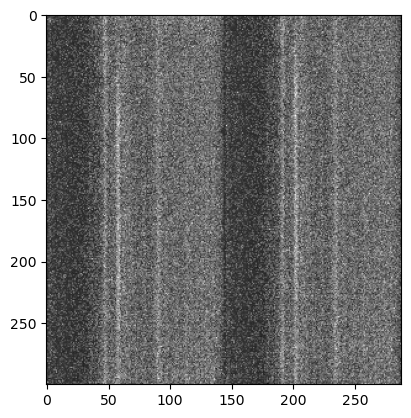

In [24]:

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

slice = frame_temp[..., 3]
plt.imshow(slice, cmap="gray", norm=mcolors.PowerNorm(0.5))
plt.show()

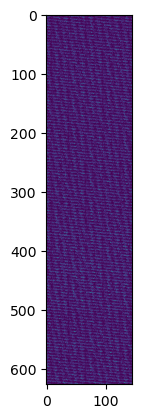

In [14]:
slice = data[:, :, 21, 2]
plt.imshow(slice)
plt.show()